# Example: Map Party Incumbents

Let’s look inside an example feed and generate a locator map to see district incumbents.

We’ll start by loading the feed.

In [1]:
import OpenPrecincts

feed = OpenPrecincts.load_feed('OpenPrecincts-Example-0.1.zip')

Next, we will merge the `elections`, `precincts`, and `candidates` tables to create a single frame with incumbent party in the `candidate_party` column.

In [2]:
import pandas

parties2014 = pandas.merge(
    pandas.merge(
        feed.elections[feed.elections.election_date == '2014-11-04'],
        feed.precincts,
        on='election_id'),
    feed.candidates[feed.candidates.candidate_incumbent == 'Yes'],
    on=('district_id', 'election_id'),
    how='left')

parties2014[[
    'election_date', 'district_id', 'county_name',
    'precinct_name', 'candidate_party', 'shape_id']].head()

,election_date,district_id,county_name,precinct_name,candidate_party,shape_id
0,2014-11-04,OPID:1360711285,ALAMANCE,01,Rep,PSID:1158854937
1,2014-11-04,OPID:1360711291,ALAMANCE,02,NaN,PSID:1158848961
2,2014-11-04,OPID:1360711291,ALAMANCE,035,NaN,PSID:1158850573
3,2014-11-04,OPID:1360711291,ALAMANCE,03C,NaN,PSID:1158854377
4,2014-11-04,OPID:1360711291,ALAMANCE,03N,NaN,PSID:1158852503


Then, we intersect the precinct and district shapes to find non-overlapping polygons that divide precincts along district boundaries. It’s uncommon for single precincts to span multiple districts, but it does happen.

In [3]:
import geopandas

out_df1 = pandas.merge(
    OpenPrecincts.add_geometry(parties2014, feed.shapes),
    OpenPrecincts.add_geometry(feed.districts, feed.shapes),
    suffixes=('_P', '_D'),
    on='district_id')

out_df1['geometry'] = \
    geopandas.GeoSeries(out_df1.geometry_P)\
    .intersection(geopandas.GeoSeries(out_df1.geometry_D))

out_df2 = geopandas.GeoDataFrame(out_df1[[
    'election_date', 'district_name', 'county_name',
    'precinct_name', 'candidate_party', 'geometry']],
    crs=feed.shapes.crs)

out_df2.head()

,election_date,district_name,county_name,precinct_name,candidate_party,geometry
0,2014-11-04,U.S. House District 2,ALAMANCE,01,Rep,POLYGON ((-79.43197308657012 35.88929191508172...
1,2014-11-04,U.S. House District 6,ALAMANCE,02,NaN,POLYGON ((-79.53483899133798 36.04382100018476...
2,2014-11-04,U.S. House District 6,ALAMANCE,035,NaN,POLYGON ((-79.50051299120325 36.15426500013933...
3,2014-11-04,U.S. House District 6,ALAMANCE,03C,NaN,"POLYGON ((-79.5203239911727 36.08219700003401,..."
4,2014-11-04,U.S. House District 6,ALAMANCE,03N,NaN,POLYGON ((-79.49082799096274 36.10568999961695...


Last, we plot the resulting frame using `OpenPrecincts.preview.parties_plot()` to color areas by the `candidate_party` column. We can use [annotations](https://matplotlib.org/users/annotations_intro.html) to call out a few points of interest. The resulting map shows two small areas of Democratic and Republic incumbency in Alamance County, and no incumbents running at all in Johnston County in 2014.

Text(-8783107.823589286, 4300621.372044271, 'Durham')

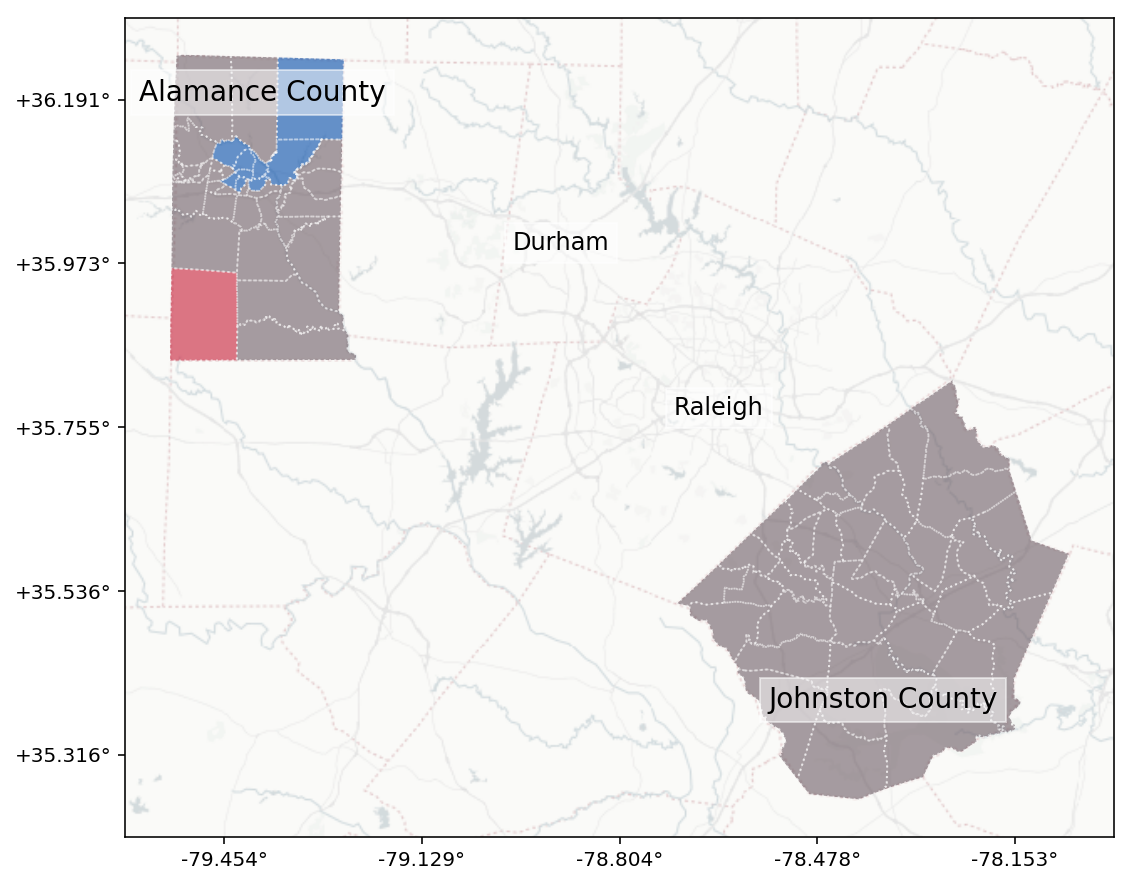

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import OpenPrecincts.preview, mercantile as m

plot = OpenPrecincts.preview.parties_plot(out_df2)

akw = dict(backgroundcolor='#ffffff80',
    verticalalignment='center', horizontalalignment='center')

plot.annotate(xy=m.xy(-79.39, 36.20), fontsize=14, s='Alamance County', **akw)
plot.annotate(xy=m.xy(-78.37, 35.39), fontsize=14, s='Johnston County', **akw)
plot.annotate(xy=m.xy(-78.64, 35.78), fontsize=12, s='Raleigh', **akw)
plot.annotate(xy=m.xy(-78.90, 36.00), fontsize=12, s='Durham', **akw)